### Import Dependencies

In [3]:
# data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer,util
import datasets as ds

# dataset
from keras.datasets import mnist
from keras.datasets import imdb

# TSNE tool
from sklearn.manifold import TSNE

# ipython magic
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Data Loading
1. Given dataset $x \in \mathbb{R}^{28 \times 28}$, $y \in \mathbb{R}$
2. Flatten so $x' \in \mathbb{R}^{784}$ (x is vector)

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"Original X_i shape: {x_train.shape}")
X = np.array([x_train[i].flatten() for i in range(x_train.shape[0])])
print(f"Flattened X_i shape: {X.shape}")

Original X_i shape: (60000, 28, 28)
Flattened X_i shape: (60000, 784)


#### Create Dataframe
1. Load X,Y into df
2. Random sample $10\%$ of data. 
    - TSNE is $O(n^2)$ so this step is helpful for inital exploration. 


In [5]:
X = pd.DataFrame(X)
Y = pd.DataFrame(y_train)
df = X
df['label'] = Y
df = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
df.shape

(6000, 785)

1. Init TSNE engine with parameters.
2. Run TSNE fitting algorithm.
*Read more about TSNE [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)*

<!-- <img src="https://imgs.xkcd.com/comics/compiling.png" width="250px"> -->

In [6]:
tsne = TSNE(n_iter=300)
tsne_results = tsne.fit_transform(df.values)

/tmp/ipykernel_233341/2796249885.py:26: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


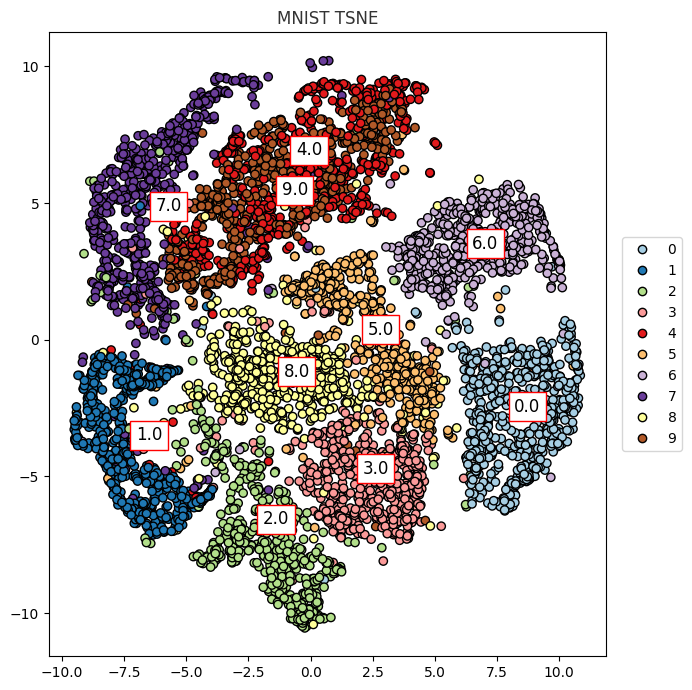

In [7]:
fig = plt.figure( figsize=(7,7) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
scatter = ax.scatter(
    x=tsne_results[:,0], 
    y=tsne_results[:,1], 
    c=df['label'], 
    cmap=plt.colormaps['Paired'], 
    alpha=1.0,
    edgecolor='black')


# Cluster labels
concatdf = pd.DataFrame(tsne_results, columns=['x', 'y'])
concatdf['label'] = df['label']
avgdf = concatdf.groupby('label').mean().reset_index()
avglabels = avgdf['label'].values
for i in range(len(avgdf)):
    cx,cy = avgdf.loc[i]['x'], avgdf.loc[i]['y']
    if i == 4: cy+=1
    tmptxt= ax.text(cx,cy, str(avgdf.loc[i]['label']), fontsize=12, color='black')
    tmptxt.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='red'))

# STYLING
t = ax.set_title("MNIST TSNE", alpha=.8, clip_on=False, y=1)
leg = ax.legend(*scatter.legend_elements(num=10), loc="right", bbox_to_anchor=(1.15, 0.5), )
for lh in leg.legendHandles: 
    lh.set_markeredgecolor('black')
plt.tight_layout()
plt.show()

### TSNE for Text Data
- We will use `goemotions` dataset that can be found [here](https://huggingface.co/datasets/go_emotions)
- Dataset description: 
    - $X:=$ sentences.
    - $Y:=$ emotion category where $y \in$ `('amusement', 'curiosity', 'confusion', 'joy', 'fear', 'sadness', 'anger')`.

#### Step 1. Load and process dataset.


In [94]:
dataset = ds.load_dataset("go_emotions", "simplified")
df = pd.DataFrame(dataset['train'])
df = df[df['labels'].map(len) == 1]
df['labels'] = df['labels'].apply(lambda x: x[0])
EMOTION_MAP={1: 'amusement', 7: 'curiosity', 6: 'confusion', 17: 'joy', 14: 'fear', 25: 'sadness', 2: 'anger'}
EMOTION_LIST=list(EMOTION_MAP.values())
df = df[df['labels'].isin(list(EMOTION_MAP.keys()))]
df['labels'] = df['labels'].apply(lambda x: EMOTION_MAP[x])
df['labels'] = df['labels'].apply(lambda x: EMOTION_LIST.index(x))
df.shape

(7024, 3)

#### Step 2. Get embeddings of data points.
- TSNE needs $N \times M$ matrix as input. 
- Let's get uniform representation of $x \Rightarrow x'= embed(x), x' \in \mathbb{R}^{384}$ 
- Let's use generic text embedding model `all-MiniLM-L6-v2` to do this. ([Model info](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)) 

In [95]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['text'].values, convert_to_tensor=True)
embeddings.shape

torch.Size([7024, 384])

#### Step 3. Run TSNE
- Same as before, we initialize TSNE engine and run `fit_transform` function.

In [96]:
engine = TSNE(n_iter=1000, perplexity=25, early_exaggeration=25, random_state=42)
tsne_embs = engine.fit_transform(embeddings.cpu().detach().numpy())
tsne_embs.shape

(7024, 2)

#### Step 4. Plot TSNE Embeddings
- We can see the plot is not as good as MNIST data.
- Training a custom classifier would learn better embedding and generate cleaner plot.

<Figure size 640x480 with 0 Axes>

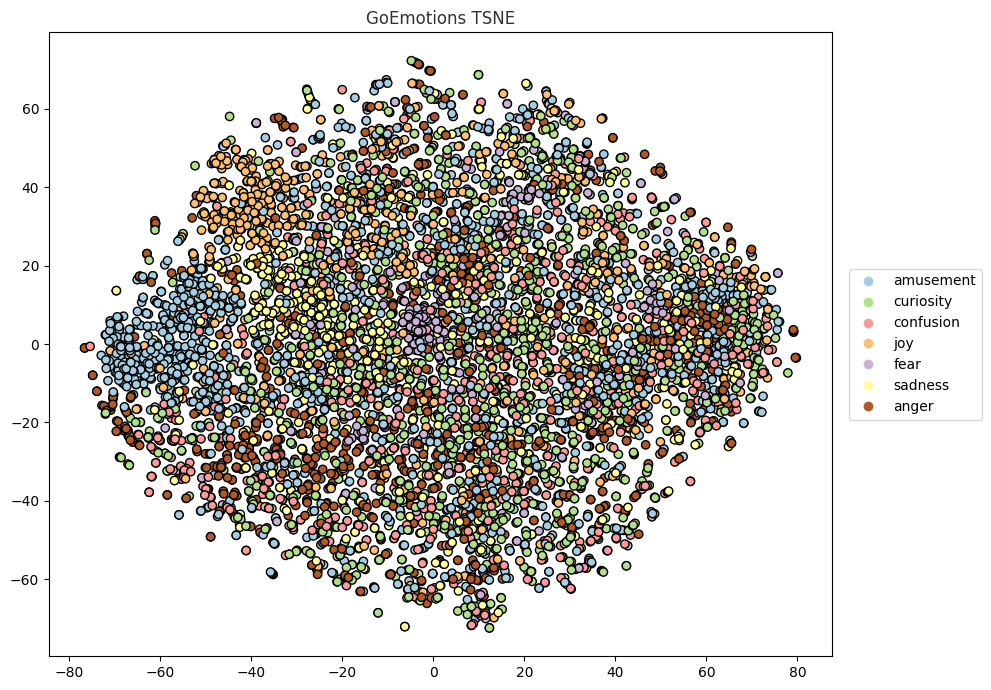

In [97]:
plt.clf()
fig = plt.figure( figsize=(10,7) )
ax = fig.add_subplot(1, 1, 1, title='TSNE' )
scatter = ax.scatter(
    x=tsne_embs[:,0], 
    y=tsne_embs[:,1], 
    c=df['labels'], 
    cmap=plt.colormaps['Paired'],
    alpha=1.0,
    edgecolor='black')
t = ax.set_title("GoEmotions TSNE", alpha=.8, clip_on=False, y=1)
leg = ax.legend(*scatter.legend_elements(num=7), loc="right", bbox_to_anchor=(1.2, 0.5), )
for i,v in enumerate(EMOTION_LIST):
    leg.get_texts()[i].set_text(v)
plt.tight_layout()
plt.show()